In [313]:
# from pymasker import LandsatMasker
# from pymasker import LandsatConfidence

# # load the QA band directly
# #
# # The "collection" parameter is required for landsat to specify the collection
# # number. Acceptable number: 0 (pre-collection), 1 (collection-1)
# #
# masker = LandsatMasker(r'..\Data\raw sat images-2014-2019\LC08_L1TP_036025_20170403_20170414_01_T1\LC08_L1TP_036025_20170403_20170414_01_T1_BQA.TIF', collection=1)

# # algorithm has high confidence that this condition exists
# # (67-100 percent confidence)
# conf = LandsatConfidence.low

# # Get mask indicating cloud pixels with high confidence
# mask = masker.get_snow_mask(conf)

# # save the result
# masker.save_tif(mask, 'result10.tif')

In [314]:
## change kernel (environment) to Acolite_env to run this cell
#!python ..\Input_models\acolite\launch_acolite.py --cli --settings=acolite_settings.txt --image=..\Data\Satellite\raw-L8-2014-2019\ImagesList_L8.txt

In [315]:
# Run this code in conda environment "MDN" to make MDN part working correctly.

In [623]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import netCDF4 as nc
import xarray as xr

In [624]:
pd.set_option('display.max_rows' ,5)

In [625]:
pd.set_option('display.max_columns' ,500)

#  field chla data preparation

In [626]:
field_data = pd.read_csv('../Data/BP_data.csv', skiprows=[1], parse_dates=['Date'], index_col= 'SampleID')
field_data

,Dataset,Date,Time,SiteNumber,latitude,Longitude,BottomDepth,sampledepth,SecchiDiskDepth,SamplingInScum,Lab_Chla,TSS,PARExtinction,TurbidityLab,TurbShallowField,DOC,Bat,WindDir,WindSp,AirTemp,RelativeHum,BarometricPress,DailyRain,PARAirFlags,PARW1,PARW2,CO2Shallow,CO2Deep,TempShallow,SpCondShallow,pHShallow,pHmVShallow,ChlRFUShallow,ChlorophyllShallow,BGAPCShallowRFU,BGAPCShallow,ODOSatShallow,ODOShallow,TempDeep,SpCondDeep,pHDeep,pHmVDeep,BGAPCDeep,BGAPCDeepRFU,ODOSatDeep,ODODeep,CDOM,CDOMmV,Temp00,Temp01,Temp02,Temp03,Temp04,shallow_sonde_biofouling_outlier,Lab_chlaOutlier,biomassCyanobacteria,biomassChlorophyte,biomassEuglenophyte,biomassChrysophyte,biomassDiatom,biomassCryptophyte,biomassDinoflagellate,biomassTotal,Cyanobacteria,Chlorophyte,Euglenophyte,Chrysophyte,Diatom,Cryptophyte,Dinoflagellate,cellcountTotal,Bluegreen_Anabaena,Bluegreen_AgmenellumMerismopedia,Bluegreen_Anacystis,Bluegreen_Gomphosphaeria,Bluegreen_Oscillatoria,Bluegreen_Aphanizomenon,Green_Chlorella,Green_Clostrium,Green_Scenedesmus,Green_Ankistrodesmus,Green_Oocystis,Green_Chodetella,Green_Botryococcus,Green_Mougeotia,Green_Phytoconis,Green_Sphaerocystis,Green_Spirogyra,Green_Tetraedron,Green_Polyedriopsis,Green_Ulothrix,Green_Pediastrum,Green_Schroderia,Diatom_Cyclotella,Diatom_Synedra,Diatom_Cocconeis,Diatom_Nitzchia,Diatom_Navicula,Diatom_Fragillaria,Diatom_Tabellaria,Diatom_Gomphenema,Diatom_Astrionella,Flagellates,Other
SampleID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,Buoy,2014-06-11,6:15:00 PM,1,50.586139,-105.384833,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.1,NaN,12.5,269.0,3.4,17.50,31.0,957.0,0.0,405.0,NaN,NaN,342.7,318.3,17.28,480.0,8.53,-116.3,2.8,11.1,3.6,11770.0,NaN,8.77,17.22,472.0,8.63,-113.9,14634.0,4.0,98.3,9.45,36.4,90.70,NaN,17.26,17.25,17.28,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Buoy,2014-06-11,6:30:00 PM,1,50.586139,-105.384833,4.3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,7.5,NaN,12.6,198.0,4.5,17.56,38.0,957.0,0.0,410.0,NaN,NaN,336.8,329.4,17.30,481.0,8.51,-115.1,2.6,10.7,3.4,11127.0,NaN,8.80,17.23,472.0,8.67,-116.3,14856.0,4.1,98.4,9.45,36.5,90.91,NaN,17.27,17.24,17.27,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110088,Calibration,2019-09-03,12:05:00 PM,1,50.586139,-105.384833,4.3,2.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110089,Calibration,2019-09-03,12:05:00 PM,1,50.586139,-105.384833,4.3,3.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [627]:
#buoy calibration
filt_dataset = field_data['Dataset'] == 'Buoy'
#field_data.loc[filt_dataset, 'Lab_Chla'] = ((100/105) * field_data[filt_dataset]['ChlRFUShallow']) ** (100/29)
field_data.loc[filt_dataset, 'Lab_Chla'] = (5 * field_data[filt_dataset]['BGAPCShallowRFU']) ** (100/99)
field_data['Lab_Chla'].head()

SampleID
1    18.533269
2    17.493540
3    16.454429
4    19.053354
5    16.454429
Name: Lab_Chla, dtype: float64

In [628]:
# drop the buoy observations associated with biofouling error
field_data = field_data[field_data['shallow_sonde_biofouling_outlier'] != 1].copy()
# drop the associated column 
field_data.drop('shallow_sonde_biofouling_outlier', axis=1, inplace=True)

In [629]:
# drop the lab observations labeld as error
field_data = field_data[field_data.Lab_chlaOutlier != 1].copy()
# drop the associated column 
field_data.drop('Lab_chlaOutlier', axis=1, inplace=True)
field_data.shape

(108778, 102)

In [630]:
# drop the observations containing bottom signal
field_data = field_data[~(field_data.SecchiDiskDepth >= field_data.BottomDepth)].copy()
field_data.shape

(108754, 102)

In [631]:
# filt_station = field_data['SiteNumber'] <5
# field_data = field_data[filt_station]

In [632]:
# filt_station = field_data['SiteNumber'] > 3
# corr_data = field_data[filt_station]

In [633]:
# corr_data.SiteNumber.where(corr_data.SiteNumber!=10, other = 9, inplace=True)
# corr_data.SiteNumber.where(corr_data.SiteNumber!=11, other = 12, inplace=True)
# corr_data.SiteNumber.where(corr_data.SiteNumber!=13, other = 12, inplace=True)
# corr_data.SiteNumber.where(corr_data.SiteNumber!=14, other = 15, inplace=True)
# corr_data.SiteNumber.where(corr_data.SiteNumber!=16, other = 15, inplace=True)

In [634]:
# corr_data.head()

In [635]:
# corr_data_grouped = corr_data.groupby(['Date','SiteNumber']).median()
# corr_data_grouped.head()

In [636]:
# corr_data_grouped = corr_data_grouped[['Lab_Chla' ,'TSS' ,'TurbShallowField','SecchiDiskDepth']].copy()

In [637]:
# corr_data_grouped['Lab_Chla'] = np.log10(corr_data_grouped['Lab_Chla']).copy()
# corr_data_grouped['TSS'] = np.log10(corr_data_grouped['TSS']).copy()
# corr_data_grouped['TurbShallowField'] = np.log10(corr_data_grouped['TurbShallowField']).copy()

In [638]:
# corr_data_grouped.rename(columns={'Lab_Chla': 'log Chla', 'TSS': 'log TSS','TurbShallowField': 'log Turbidity','SecchiDiskDepth': 'SDD'}, inplace=True)

In [639]:
# corr_data_grouped_final = corr_data_grouped.dropna(how='any',axis=0)
# corr_data_grouped_final.head()

In [640]:
# corr_data_grouped_final.reset_index(inplace=True)
# corr_data_grouped_final.head()

In [641]:
# import seaborn as sns

In [642]:
# corr_data_grouped_final['SiteNumber'] = corr_data_grouped_final['SiteNumber'].astype(str).copy()

In [643]:
# # Function to calculate correlation coefficient between two arrays
# def corr(x, y, **kwargs):
    
#     # Calculate the value
#     coef = np.corrcoef(x, y)[0][1]
#     # Make the label
#     label = r'$\rho$ = ' + str(round(coef, 2))
    
#     # Add the label to the plot
#     ax = plt.gca()
#     ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)
    
# # Function to calculate Number of observation to plot on histograms
# def num_obs(x, **kwargs):
    
#     # Calculate the value
#     num_obs = np.count_nonzero(~np.isnan(x))
#     # Make the label
#     label = 'N = ' + str(num_obs)
    
#     # Add the label to the plot
#     ax = plt.gca()
#     ax.annotate(label, xy = (0.2, 0.95), size = 20, xycoords = ax.transAxes)
    
# grid = sns.PairGrid(data= corr_data_grouped_final, vars = ['log Chla','log TSS', 'log Turbidity', 'SDD'])
# # Map the plots to the locations

# grid = grid.map_upper(corr)
# grid = grid.map_diag(num_obs)

# # Now set parameters needed for `hue`
# hue_vals = corr_data_grouped_final["SiteNumber"]
# grid.hue_names = corr_data_grouped_final["SiteNumber"].unique()
# palette_value = sns.color_palette("magma", len(grid.hue_names))

# grid = grid.map_upper(sns.scatterplot, hue = hue_vals, palette = palette_value)
# grid = grid.map_lower(sns.kdeplot, hue = hue_vals, palette = palette_value)
# grid = grid.map_diag(sns.histplot, hue = hue_vals, palette = palette_value,multiple="stack", element="step");
# grid = grid.add_legend(title = 'Station')
                    
#  # vars = ['Lab_Chla','TSS', 'TurbShallowField', 'SecchiDiskDepth'], hue="SiteNumber",hue_order=['4','5','6','7','8','9','12','15'],palette='magma')

In [644]:
# grid.savefig('corrplot.png',dpi=500, format='png')

In [645]:
# averaging field chla data over date and station
chl_data = field_data.groupby(['Date', 'SiteNumber', 'latitude', 'Longitude']).agg({'Lab_Chla' :'median'})
chl_data

,,,,Lab_Chla
Date,SiteNumber,latitude,Longitude,
2014-01-06,2,50.585203,-105.385823,NaN
2014-01-13,2,50.585203,-105.385823,6.000000
...,...,...,...,...
2019-10-02,1,50.586139,-105.384833,39.946201
2019-10-03,1,50.586139,-105.384833,41.518573


In [646]:
# drop (dates,stations) with no chla measured
chl_data.dropna(axis=0, inplace=True)
chl_data.head()

,,,,Lab_Chla
Date,SiteNumber,latitude,Longitude,
2014-01-13,2,50.585203,-105.385823,6.0
2014-01-27,2,50.585203,-105.385823,7.0
2014-02-10,2,50.585203,-105.385823,19.0
2014-02-24,2,50.585203,-105.385823,14.0
2014-03-10,2,50.585203,-105.385823,8.0


In [647]:
chl_data.reset_index(level=['Date', 'SiteNumber', 'latitude', 'Longitude'], inplace=True)
chl_data.index
chl_data.dtypes

Date          datetime64[ns]
SiteNumber             int64
latitude             float64
Longitude            float64
Lab_Chla             float64
dtype: object

# Extract satelite data

In [648]:
# create a dataframe for images in the directory
import os, fnmatch

listOfFiles = os.listdir('../Data/Satellite/Processed_sat-2014-2019')
pattern = "S2*_L2W.nc"
img_list = []
for entry in listOfFiles:
    if fnmatch.fnmatch(entry, pattern):
            img_list.append(entry)

if fnmatch.fnmatch(pattern, 'S2*'):
    img_dates = [i[8:18] for i in img_list] #for S2
elif fnmatch.fnmatch(pattern, 'L8*'):
    img_dates = [i[7:17] for i in img_list] #for L8
    
number_of_images = len(img_list)
sat_dates = pd.DataFrame(data = img_dates, columns = ['Date'], index = range(0, number_of_images))
sat_dates['#img'] = range(0, number_of_images)
sat_dates.head()
sat_dates

,Date,#img
0,2017_04_08,0
1,2017_04_15,1
...,...,...
70,2019_10_20,70
71,2019_10_30,71


In [649]:
sat_dates.sort_values('Date',inplace = True)
sat_dates.head()

,Date,#img
0,2017_04_08,0
1,2017_04_15,1
2,2017_04_28,2
3,2017_05_05,3
4,2017_05_18,4


In [650]:
sat_dates['Date'] = pd.to_datetime(sat_dates['Date'], format='%Y_%m_%d')

In [651]:
# create a dataframe from merging chla data and image names (based on same date)
merged_data = pd.merge_asof(chl_data.rename(columns={'Date':'Date_insitu'}), sat_dates.rename(columns={'Date':'Date_sat'}), left_on='Date_insitu', right_on='Date_sat',direction='nearest',tolerance=pd.Timedelta('3d'))
merged_data

,Date_insitu,SiteNumber,latitude,Longitude,Lab_Chla,Date_sat,#img
0,2014-01-13,2,50.585203,-105.385823,6.000000,NaT,NaN
1,2014-01-27,2,50.585203,-105.385823,7.000000,NaT,NaN
...,...,...,...,...,...,...,...
1206,2019-10-02,1,50.586139,-105.384833,39.946201,2019-10-05,41.0
1207,2019-10-03,1,50.586139,-105.384833,41.518573,2019-10-05,41.0


In [652]:
merged_data.dropna(axis=0, subset = ['#img'], inplace=True)
merged_data

,Date_insitu,SiteNumber,latitude,Longitude,Lab_Chla,Date_sat,#img
583,2017-04-10,2,50.585203,-105.385823,20.000000,2017-04-08,0.0
584,2017-05-08,2,50.585203,-105.385823,16.000000,2017-05-05,3.0
...,...,...,...,...,...,...,...
1206,2019-10-02,1,50.586139,-105.384833,39.946201,2019-10-05,41.0
1207,2019-10-03,1,50.586139,-105.384833,41.518573,2019-10-05,41.0


In [653]:
merged_data['date_diff'] = abs(merged_data['Date_sat'] - merged_data['Date_insitu'])
merged_data

,Date_insitu,SiteNumber,latitude,Longitude,Lab_Chla,Date_sat,#img,date_diff
583,2017-04-10,2,50.585203,-105.385823,20.000000,2017-04-08,0.0,2 days
584,2017-05-08,2,50.585203,-105.385823,16.000000,2017-05-05,3.0,3 days
...,...,...,...,...,...,...,...,...
1206,2019-10-02,1,50.586139,-105.384833,39.946201,2019-10-05,41.0,3 days
1207,2019-10-03,1,50.586139,-105.384833,41.518573,2019-10-05,41.0,2 days


In [654]:
merged_data_3daylag = merged_data.sort_values(by=['Date_sat', 'SiteNumber', 'date_diff']).drop_duplicates(subset=['#img', 'SiteNumber'], keep='first', inplace=False)
merged_data_3daylag

,Date_insitu,SiteNumber,latitude,Longitude,Lab_Chla,Date_sat,#img,date_diff
583,2017-04-10,2,50.585203,-105.385823,20.000000,2017-04-08,0.0,2 days
584,2017-05-08,2,50.585203,-105.385823,16.000000,2017-05-05,3.0,3 days
...,...,...,...,...,...,...,...,...
1199,2019-09-25,1,50.586139,-105.384833,37.850673,2019-09-25,40.0,0 days
1207,2019-10-03,1,50.586139,-105.384833,41.518573,2019-10-05,41.0,2 days


In [655]:
merged_data_3daylag.reset_index(inplace= True)
merged_data_3daylag.drop('index', axis=1, inplace=True)

In [656]:
merged_data_3daylag['#img'] = merged_data_3daylag['#img'].astype('int32', copy = True)
merged_data_3daylag

,Date_insitu,SiteNumber,latitude,Longitude,Lab_Chla,Date_sat,#img,date_diff
0,2017-04-10,2,50.585203,-105.385823,20.000000,2017-04-08,0,2 days
1,2017-05-08,2,50.585203,-105.385823,16.000000,2017-05-05,3,3 days
...,...,...,...,...,...,...,...,...
185,2019-09-25,1,50.586139,-105.384833,37.850673,2019-09-25,40,0 days
186,2019-10-03,1,50.586139,-105.384833,41.518573,2019-10-05,41,2 days


In [657]:
# # still not working for S2 images because of different bands in S2A and S2B. I think the best practice for S2 images is to read A and B in different datasets and then change the keys in the second one to be consistent with the first one and then merge them in one dataset.
path_img = '../Data/Satellite/Processed_sat-2014-2019/'

# for index in range(len(img_list)):
#     if index == 0:
#         imgs = xr.open_dataset(path_img + img_list[index], decode_times=False)
#         imgs.coords['Date'] = sat_dates['Date'][index]
#     else:
#         ds = xr.open_dataset(path_img + img_list[index], decode_times=False)
#         ds.coords['Date'] = sat_dates['Date'][index]
#         imgs = xr.concat([imgs,ds],'Date').copy()

In [658]:
# # I couldnt use this method becasue of inconsistencies in netcdf files
# imgs = xr.open_mfdataset([os.path.join(path, name) for name in img_list], combine = 'nested', compat='override',decode_times=False)

In [659]:
# extracting reflectance values of correspond pixels to in-situ data
Ref = [[]*0]*0
pixel = [[]*0]*0
for index, row in merged_data_3daylag.iterrows():
    #print(index)
    ds = nc.Dataset('../Data/Satellite/Processed_sat-2014-2019/' + img_list[merged_data_3daylag.loc[index]['#img']])
    keys = ds.variables.keys()
    ds_1D = {}
    for key in keys:
        ds_1D[key] = ds.variables[key][:].flatten(order='C')

    dist = ((ds_1D['lon'][:] - row['Longitude']) ** 2 + (ds_1D['lat'][:] - row['latitude']) ** 2) ** (1/2) 
    idx_mins = dist.argsort()[:9]
    #print(idx_mins)
    idx_min = idx_mins[0]
    
    pix_Y = idx_min // ds.dimensions['x'].size
    pix_X = idx_min % ds.dimensions['x'].size
    pix = [pix_Y, pix_X]
    pixel.append(pix)
    
    Rrs = []
    for key in keys:
        if 'Rrs' in key:   # products: Rrs, rhot, and rhorc      
            if (ds_1D['l2_flags'][idx_min]) == 0: # I added this condition to mask rhot and rhorc products which are not filtered by default in Acolite 
    #           Rrs.append((ds_1D[key][idx_mins]).mean())
                Rrs.append((ds_1D[key][idx_min]))
            
    Ref.append(Rrs)

the result of above method to extract reflectance values was checked with PixEx method in SNAP. there is slight different in extracted pixelss. from 9 pixels extrscted 2 of them were different between two mwthods. but dont think it has much effect on results. also the above method put nan for if the window contains even one nan value. which I think makes sense to avoid adjacency effects of cloud and so on. however it can be replaced with nonmean mehthod.

In [660]:
# name of columns to add to dataframe
#added_ref = ['Rrs_443', 'Rrs_492', 'Rrs_560' , 'Rrs_665', 'Rrs_704', 'Rrs_740', 'Rrs_783', 'Rrs_833', 'Rrs_865', 'Rrs_945', 'Rrs_1373', 'Rrs_1614' , 'Rrs_2202'] # for S2-rhot
added_ref = ['Rrs_443', 'Rrs_492', 'Rrs_560' , 'Rrs_665', 'Rrs_704', 'Rrs_740', 'Rrs_783', 'Rrs_833', 'Rrs_865', 'Rrs_1614' , 'Rrs_2202'] # for S2
#added_ref = ['Rrs_443', 'Rrs_483', 'Rrs_561' , 'Rrs_655', 'Rrs_865', 'Rrs_1609', 'Rrs_2201'] # for L8

In [661]:
# crate a dataframe of ref data
sat_ref = pd.DataFrame(data = Ref, columns = added_ref)
sat_ref

,Rrs_443,Rrs_492,Rrs_560,Rrs_665,Rrs_704,Rrs_740,Rrs_783,Rrs_833,Rrs_865,Rrs_1614,Rrs_2202
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.000036,0.002302,0.008244,0.001386,0.000821,-0.000318,-0.000481,-0.000355,-0.000520,0.000018,0.0
...,...,...,...,...,...,...,...,...,...,...,...
185,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,0.001056,0.003260,0.008091,0.004065,0.005244,0.003641,0.003520,0.003421,0.002957,0.000576,0.0


# attach extracted ref data to field dataframe


In [662]:
# concating chla and ref dataframes 
samples = pd.concat([merged_data_3daylag, pd.DataFrame(pixel,columns=['pix_Y','pix_X']), sat_ref], axis = 1)
print(samples.shape)
samples

(187, 21)


,Date_insitu,SiteNumber,latitude,Longitude,Lab_Chla,Date_sat,#img,date_diff,pix_Y,pix_X,Rrs_443,Rrs_492,Rrs_560,Rrs_665,Rrs_704,Rrs_740,Rrs_783,Rrs_833,Rrs_865,Rrs_1614,Rrs_2202
0,2017-04-10,2,50.585203,-105.385823,20.000000,2017-04-08,0,2 days,344,490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2017-05-08,2,50.585203,-105.385823,16.000000,2017-05-05,3,3 days,344,490,0.000036,0.002302,0.008244,0.001386,0.000821,-0.000318,-0.000481,-0.000355,-0.000520,0.000018,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
185,2019-09-25,1,50.586139,-105.384833,37.850673,2019-09-25,40,0 days,342,491,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
186,2019-10-03,1,50.586139,-105.384833,41.518573,2019-10-05,41,2 days,342,491,0.001056,0.003260,0.008091,0.004065,0.005244,0.003641,0.003520,0.003421,0.002957,0.000576,0.0


# bad pixel handeling

 I decided to use only acolite to remove bad pixels (it includes removing cloud, some shadows and negative refs) and then use a outlier detection to remove bad refs. I thnik it is enough based on no significant difference with method below which was based on manuall detection.

In [663]:
#drop missing values in ref 
samples = samples.dropna(axis=0, how='any').copy()
sat_ref = sat_ref.dropna(axis=0, how='any').copy()
samples.shape
print(sat_ref.shape)

(139, 11)


In [664]:
# samples.to_csv('vis_forbadpixeldetermination.csv')
# bad_pixels = np.genfromtxt('badpixels_L8_samedaySamples.csv', delimiter=',')
# filt_bad_pixels = bad_pixels < 1
# samples_filtered = samples[filt_bad_pixels].copy()
# samples_filtered

In [665]:
#samples.filter(like='Rrs_').transpose().plot()

In [666]:
filt_outliers = samples['Rrs_443'].between(samples['Rrs_443'].quantile(.05), samples['Rrs_443'].quantile(.95))
samples = samples[filt_outliers]
sat_ref = sat_ref[filt_outliers][:]
#samples.filter(like='Rrs_').transpose().plot()
print(samples.shape)
print(sat_ref.shape)

(125, 21)
(125, 11)


In [667]:
samples

,Date_insitu,SiteNumber,latitude,Longitude,Lab_Chla,Date_sat,#img,date_diff,pix_Y,pix_X,Rrs_443,Rrs_492,Rrs_560,Rrs_665,Rrs_704,Rrs_740,Rrs_783,Rrs_833,Rrs_865,Rrs_1614,Rrs_2202
1,2017-05-08,2,50.585203,-105.385823,16.000000,2017-05-05,3,3 days,344,490,0.000036,0.002302,0.008244,0.001386,0.000821,-0.000318,-0.000481,-0.000355,-0.000520,0.000018,0.0
2,2017-05-18,1,50.586139,-105.384833,3.033477,2017-05-18,4,0 days,342,491,0.000350,0.002114,0.007294,0.001184,0.001301,0.000634,0.001047,0.000987,0.000804,0.000217,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
184,2019-09-23,15,50.735690,-105.626390,11.320000,2019-09-22,39,1 days,64,208,0.003406,0.004933,0.011380,0.006363,0.005909,0.003568,0.003143,0.002944,0.002859,0.000738,0.0
186,2019-10-03,1,50.586139,-105.384833,41.518573,2019-10-05,41,2 days,342,491,0.001056,0.003260,0.008091,0.004065,0.005244,0.003641,0.003520,0.003421,0.002957,0.000576,0.0


# feature engineering


In [668]:
y = samples.Lab_Chla
X = samples.drop('Lab_Chla', axis = 1)
X.head()

,Date_insitu,SiteNumber,latitude,Longitude,Date_sat,#img,date_diff,pix_Y,pix_X,Rrs_443,Rrs_492,Rrs_560,Rrs_665,Rrs_704,Rrs_740,Rrs_783,Rrs_833,Rrs_865,Rrs_1614,Rrs_2202
1,2017-05-08,2,50.585203,-105.385823,2017-05-05,3,3 days,344,490,0.000036,0.002302,0.008244,0.001386,0.000821,-0.000318,-0.000481,-0.000355,-0.000520,0.000018,0.000000
2,2017-05-18,1,50.586139,-105.384833,2017-05-18,4,0 days,342,491,0.000350,0.002114,0.007294,0.001184,0.001301,0.000634,0.001047,0.000987,0.000804,0.000217,0.000000
3,2017-05-15,4,50.586530,-105.384210,2017-05-18,4,3 days,341,492,0.000301,0.002465,0.007444,0.001020,0.000942,0.000828,0.000831,0.000838,0.000544,0.000000,0.000074
4,2017-05-15,5,50.573180,-105.341740,2017-05-18,4,3 days,366,542,0.001168,0.003946,0.010223,0.002869,0.002622,0.001241,0.001239,0.001751,0.000860,0.000320,0.000000
5,2017-05-15,6,50.617800,-105.443830,2017-05-18,4,3 days,283,422,0.000228,0.002092,0.005384,0.000941,0.001093,0.001267,0.001492,0.001270,0.001402,0.000183,0.000000


In [669]:
y_trans_log10 = np.log10(y)
len(y_trans_log10)

125

In [670]:
# computing traditional models
X['NDCI'] = (X['Rrs_704']- X['Rrs_665']) / (X['Rrs_704']+  X['Rrs_665'])
X['M09'] = X['Rrs_704'] / X['Rrs_665']
#X['T07'] = X['Rrs_665'] / X['Rrs_560']
X['D05'] = (X['Rrs_665']**(-1) - X['Rrs_704']**(-1)) * X['Rrs_740']
X['OC2'] = X['Rrs_492'] / X['Rrs_560']
X['OC3'] = pd.concat([X['Rrs_492'],X['Rrs_443']], axis=1).max(axis=1) / X['Rrs_560']  

In [671]:
selected_features = []
selected_features = added_ref[:6]
# selected_features.append('SiteNumber')
# selected_features.append('NDCI')
# selected_features.append('M09')
# selected_features.append('D05')
# selected_features.append('OC3')
X_sel = pd.DataFrame(X[selected_features])
X_sel

,Rrs_443,Rrs_492,Rrs_560,Rrs_665,Rrs_704,Rrs_740
1,0.000036,0.002302,0.008244,0.001386,0.000821,-0.000318
2,0.000350,0.002114,0.007294,0.001184,0.001301,0.000634
...,...,...,...,...,...,...
184,0.003406,0.004933,0.011380,0.006363,0.005909,0.003568
186,0.001056,0.003260,0.008091,0.004065,0.005244,0.003641


In [672]:
# #from sklearn.preprocessing import scale
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# X_sel_standard = scaler.fit_transform(X_sel)
# plt.hist(X_sel_standard)

# Model development

In [673]:
# ## import models
# #from sklearn.tree import DecisionTreeRegressor
# #from sklearn.ensemble import RandomForestRegressor
#from xgboost import XGBRegressor
from sklearn.svm import SVR
#from sklearn.linear_model import LinearRegression
# #from sklearn.cross_decomposition import PLSRegression

# #model = DecisionTreeRegressor(max_depth=100)
# #model = RandomForestRegressor(n_estimators=100, random_state=0)
#model = XGBRegressor(booster='gblinear',n_estimators=100, random_state=0, learning_rate = 0.1)
model = SVR(kernel = 'rbf', gamma = 'scale')
#model = LinearRegression()
# #model = PLSRegression(n_components = 4)


In [674]:
# create a pipeline
from sklearn.pipeline import Pipeline
my_pipeline = Pipeline(steps=[('model', model)])

In [675]:
# cross validation and accuracy assessment of model
from sklearn.model_selection import cross_val_score
mae_loginput = 10**(-1 * cross_val_score(my_pipeline, X_sel, y_trans_log10, cv=5, scoring='neg_mean_absolute_error').mean())
round(mae_loginput,2)

1.51

In [697]:
# getting predictions from cross validation
from sklearn.model_selection import cross_val_predict
y_pred = cross_val_predict(my_pipeline, X_sel, y_trans_log10, cv=5)

# Implement MDN

In [369]:
# # prepare and save data to import to MDN
# sat_ref_MDN = np.array(sat_ref.dropna(axis=0))[:,:7]
# print(sat_ref_MDN.shape)
# np.savetxt("sat_ref_MDN.csv", sat_ref_MDN, delimiter=",")

In [370]:
# %%cmd
# ## change kernel (environment) to MDN_env to run this cell - I put the MDN folder in the directory of MDN_env
# # Run MDN with bash or using !
# python -m MDN --sensor S2A sat_ref_MDN.csv

In [371]:
# # read the output of MDN model and make format consistent with other models' outputs 
# y_pred = pd.read_csv('MDN_sat_ref_MDN.csv')
# y_pred = np.transpose(np.array(np.log10(y_pred)))
# y_pred

In [372]:
# from sklearn.metrics import mean_absolute_error

# mae_loginput = 10**(mean_absolute_error(np.transpose(y_pred), y_trans_log10))
# round(mae_loginput,2)

# bst_oli (Cao et al., 2020)

In [373]:
# # Rayleigh-corrected reflectance should be intrudeced to the model as input
# import xgboost as xgb
# bst = xgb.Booster({'nthread': 4})  # init model
# bst.load_model('bst_oli\chl_bst_model_release.model')  # load data
# dtest = xgb.DMatrix(X_sel_standard)
# y_pred = np.log10(bst.predict(dtest))
# y_pred

# validation performance

In [699]:
from scipy.io import savemat
savemat('y_pred.mat', {'y_pred': y_pred})
#y_trans_log10[y_trans_log10 == 0] = 0.05
savemat('y.mat', {'y': np.array(y_trans_log10)})

# Spatial check

In [677]:
# imgs['Rrs_1610'][0,:,:].plot.imshow()
# plt.gca().invert_yaxis()

# R = nc.variables['Rrs_665'][:]
# G = nc.variables['Rrs_559'][:] 
# B = nc.variables['Rrs_442'][:] 

In [678]:
import fiona

shp = fiona.open("..\Data\Maps_BP\BP - Study Site\BP_Shapefile\Buffalo_Pound.shp")
pol = shp.next()

<ipython-input-678-783b5be4fcfc>:4: FionaDeprecationWarning: Collection.__next__() is buggy and will be removed in Fiona 2.0. Switch to `next(iter(collection))`.
  pol = shp.next()


In [679]:
from shapely.geometry import Point, shape
polygon = shape(pol['geometry'])

In [680]:
dataset = nc.Dataset(path_img + img_list[62])
dataset
lats = dataset.variables['lat'][:].flatten()
lons = dataset.variables['lon'][:].flatten()

In [681]:
mask_flat = []
for i in range(len(lats)):
    point = Point(lons[i], lats[i])
    mask_flat.append(point.within(polygon))

In [682]:
from netCDF4 import Dataset
#Ref = [[]*0]*0 
#for index, row in merged_data_3daylag.iterrows():
dataset = Dataset(path_img + img_list[62])
keys = dataset.variables.keys()
dataset_1D = {}
for key in keys:
    dataset_1D[key] = dataset.variables[key][:].flatten()
    


In [683]:
Ref = [[]*0]*0 
for i in range(0,len(dataset_1D['lat'])):
    if mask_flat[i] == True and dataset_1D['l2_flags'][i] == 0:
        Rrs = []
        for key in keys:
            if 'Rrs' in key:        
                Rrs.append(dataset_1D[key][i])
        Ref.append(Rrs)
        
ww = (np.array(Ref))   
ww = ww[:, :6]

In [684]:
# from sklearn.preprocessing import scale 
# ww_scaled = scale(ww)
# ww_scaled

In [685]:
# def reject_outliers(data, m):
#     return abs(data - np.median(data)) > m * np.std(data)

# idx = ww.copy()
# for i in range(0, ww.shape[1]):
#     data = ww[:,i]
#     idx[:,i] = reject_outliers(data, 2)

# idx_outlier = idx.sum(axis=1) != 0

In [686]:
model.fit(X_sel, y_trans_log10)
values_pred = model.predict(ww)
# idx_values_pred_outlier = reject_outliers(values_pred, 2)
# values_pred[idx_values_pred_outlier] = 'NaN'
values_pred_unlog = 10 ** values_pred
# values_pred_unlog[idx_outlier] = 'NaN'


In [687]:
image_flat = np.array(dataset_1D['Rrs_492']) 
idx = ~np.isnan(image_flat) & np.array(mask_flat)
image_flat[idx]= values_pred_unlog
image_flat[~idx] = 'NaN'

In [688]:
image = image_flat.reshape(dataset.dimensions['y'].size, dataset.dimensions['x'].size)

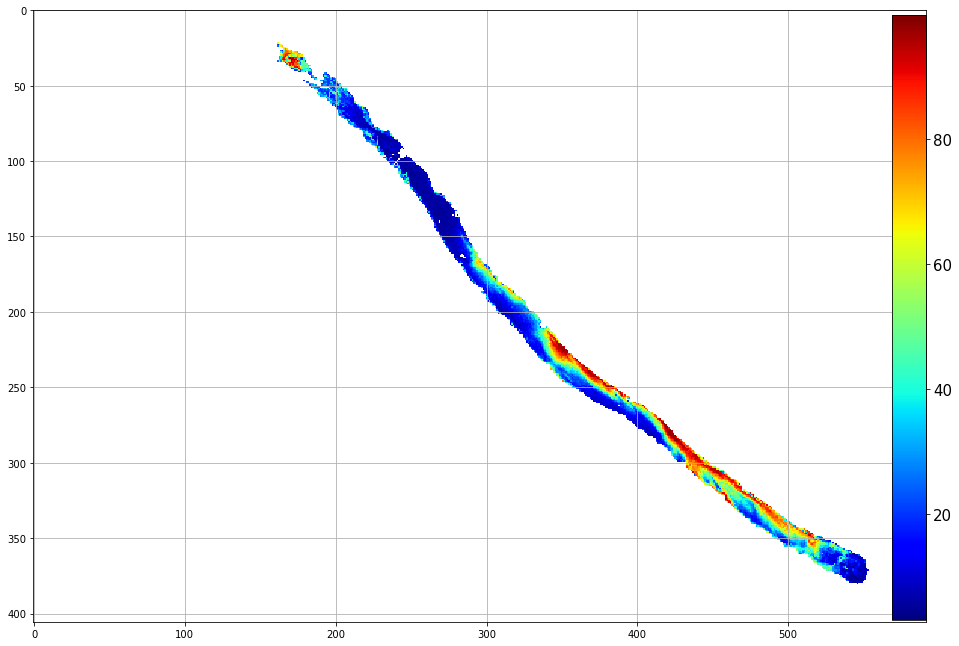

In [689]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

ax = plt.figure(figsize = [16,12])
heatmap = plt.imshow(image, cmap='jet', interpolation='nearest')
plt.grid()

cbar = plt.colorbar(heatmap, cax = ax.add_axes([.87, 0.15, 0.03, 0.7]))
cbar.ax.tick_params(labelsize=15) 



In [690]:
ax.savefig('test.png',dpi=500, format='png')

# temporal check

In [691]:
samples_sel = samples[(samples['Date_insitu'].dt.year==2018) & (samples['SiteNumber']==1) & (samples['date_diff']=='0 days')]
samples_sel

,Date_insitu,SiteNumber,latitude,Longitude,Lab_Chla,Date_sat,#img,date_diff,pix_Y,pix_X,Rrs_443,Rrs_492,Rrs_560,Rrs_665,Rrs_704,Rrs_740,Rrs_783,Rrs_833,Rrs_865,Rrs_1614,Rrs_2202
55,2018-05-30,1,50.586139,-105.384833,2.523246,2018-05-30,15,0 days,342,491,0.005580,0.004144,0.004536,0.001375,0.001062,0.002429,0.002443,0.001498,0.002220,0.000000,0.000985
56,2018-06-07,1,50.586139,-105.384833,3.544571,2018-06-07,49,0 days,342,491,0.002765,0.006234,0.011045,0.004558,0.004279,0.006239,0.006352,0.006323,0.005919,0.000782,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,2018-09-05,1,50.586139,-105.384833,35.756304,2018-09-05,56,0 days,342,491,0.001424,0.004137,0.013183,0.005190,0.006793,0.002993,0.003314,0.002551,0.002055,0.000387,0.000000
106,2018-09-07,1,50.586139,-105.384833,31.048575,2018-09-07,23,0 days,342,491,0.001727,0.005300,0.014841,0.007728,0.008663,0.005440,0.005488,0.004739,0.004740,0.000887,0.000000


In [692]:
ref_sel = samples_sel.filter(like='Rrs')
ref_sel

,Rrs_443,Rrs_492,Rrs_560,Rrs_665,Rrs_704,Rrs_740,Rrs_783,Rrs_833,Rrs_865,Rrs_1614,Rrs_2202
55,0.005580,0.004144,0.004536,0.001375,0.001062,0.002429,0.002443,0.001498,0.002220,0.000000,0.000985
56,0.002765,0.006234,0.011045,0.004558,0.004279,0.006239,0.006352,0.006323,0.005919,0.000782,0.000000
...,...,...,...,...,...,...,...,...,...,...,...
105,0.001424,0.004137,0.013183,0.005190,0.006793,0.002993,0.003314,0.002551,0.002055,0.000387,0.000000
106,0.001727,0.005300,0.014841,0.007728,0.008663,0.005440,0.005488,0.004739,0.004740,0.000887,0.000000


In [693]:
y_pred = model.predict(ref_sel.iloc[:,:6])

In [334]:
chl_data_sel = chl_data[(chl_data['Date'].dt.year==2018) & (chl_data['SiteNumber']==1)]
chl_data_sel

,Date,SiteNumber,latitude,Longitude,Lab_Chla
822,2018-05-29,1,50.586139,-105.384833,2.014052
823,2018-05-30,1,50.586139,-105.384833,2.523246
824,2018-05-31,1,50.586139,-105.384833,3.544571
825,2018-06-01,1,50.586139,-105.384833,4.056406
826,2018-06-02,1,50.586139,-105.384833,5.081949
...,...,...,...,...,...
1008,2018-09-30,1,50.586139,-105.384833,19.053354
1009,2018-10-01,1,50.586139,-105.384833,16.454429
1010,2018-10-02,1,50.586139,-105.384833,14.378219
1011,2018-10-03,1,50.586139,-105.384833,12.823008


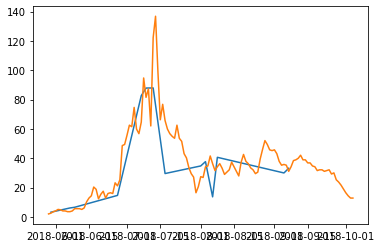

In [336]:
plt.plot(samples_sel['Date_insitu'],10**y_pred)
plt.plot(chl_data_sel['Date'], chl_data_sel['Lab_Chla'])
plt.show()